In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import pearsonr
from torchvision.models import alexnet  # Assuming using pretrained AlexNet from torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import os
from PIL import Image
from torchvision import models, transforms

from torchvision.models import alexnet, AlexNet_Weights
from utils import Device, ANET

In [2]:
def preprocess_image(images):
    if images.dtype != np.float32:
        images = images.astype(np.float32)
    
    if images.max() > 1.0:
        images /= 255.0
    
    images = (images * 255).astype(np.uint8)
        
    transform = Compose([
        Resize((224, 224)),  # Example resize, adjust to your needs
        ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    transformed_images = []
    for img in images:
        img_pil = Image.fromarray(img)
        transformed_img = transform(img_pil)
        transformed_images.append(transformed_img)
    
    batch = torch.stack(transformed_images)
    
    return batch
    


def evaluate_AlexNet_conv(target_layer, recon_path, stim_path):

    image_batch = np.load(stim_path)
    recon_batch = np.load(recon_path).transpose(0,2,3,1)  # Ensure this returns a batch of images with shape (N, 96, 96, 3)

    stimuli = preprocess_image(image_batch).to(device)
    recons = preprocess_image(recon_batch).to(device)
    with torch.no_grad():
        fs = target_layer(stimuli)
        fs_hat = target_layer(recons)

        plt.figure(figsize=(2,1))
        
        plt.subplot(1,2,1)
        plt.imshow(fs[0][0].cpu().numpy())
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(fs_hat[0][0].cpu().numpy())
        plt.axis('off')
        plt.show()
        plt.close()

    corr, dist = pearsonr(fs.flatten().cpu().numpy(), fs_hat.flatten().cpu().numpy())[0], ((fs - fs_hat) ** 2).mean().item()
    
    return corr, dist


def evaluate_AlexNet_fc(fc_layer, recon_path, stim_path):

    image_batch = np.load(stim_path)
    recon_batch = np.load(recon_path).transpose(0,2,3,1)  # Ensure this returns a batch of images with shape (N, 96, 96, 3)

    stimuli = preprocess_image(image_batch).to(device)
    recons = preprocess_image(recon_batch).to(device)
    with torch.no_grad():
        flattened_fc_input = torch.flatten(avgpool(conv5(stimuli)), 1)
        print(flattened_fc_input.shape)
        fs = fc_layer(flattened_fc_input)
        print(fs.shape)
        fs_hat = fc_layer(torch.flatten(avgpool(conv5(recons)), 1))

    corr, dist = pearsonr(fs.flatten().cpu().numpy(), fs_hat.flatten().cpu().numpy())[0], ((fs - fs_hat) ** 2).mean().item()
    
    return corr, dist


In [3]:
device = torch.device("cuda:0")
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).to(device)
model.eval()

conv1 = model.features[:3]
conv2 = model.features[:6]
conv3 = model.features[:7]
conv4 = model.features[:9]
conv5 = model.features[:13]

avgpool = model.avgpool

fc6 = model.classifier[:3]
fc7 = model.classifier[:5]
fc8 = model.classifier


conv_layers = [
    conv1,
    conv2,
    conv3,
    conv4,
    conv5
]

fc_layers =[
    fc6,
    fc7,
    fc8
]


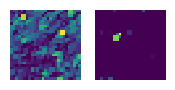

cor recons.npy Layer Index: 0: 0.3023
dist recons.npy Layer Index: 0: 4.0
--


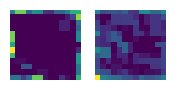

cor recons.npy Layer Index: 1: 0.2308
dist recons.npy Layer Index: 1: 9.0
--


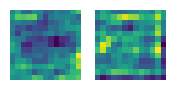

cor recons.npy Layer Index: 2: 0.3545
dist recons.npy Layer Index: 2: 87.0
--


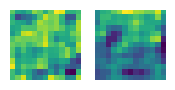

cor recons.npy Layer Index: 3: 0.3529
dist recons.npy Layer Index: 3: 33.0
--


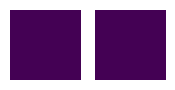

cor recons.npy Layer Index: 4: 0.2749
dist recons.npy Layer Index: 4: 2.0
--
torch.Size([100, 9216])
torch.Size([100, 4096])
cor recons.npy Layer Index: 0: 0.3097
dist recons.npy Layer Index: 0: 3.0
--
torch.Size([100, 9216])
torch.Size([100, 4096])
cor recons.npy Layer Index: 1: 0.5047
dist recons.npy Layer Index: 1: 18.0
--
torch.Size([100, 9216])
torch.Size([100, 1000])
cor recons.npy Layer Index: 2: 0.515
dist recons.npy Layer Index: 2: 8.0
--
 -- SAVED -- cor_a recons.npy pool
 -- SAVED -- dis_a recons.npy pool


In [17]:
import gc

which_recons = 'c_64'

file_name = [
    'recons.npy',
]


for rec in file_name:
    
    os.makedirs(f'correlations/{which_recons}/{rec[:-4]}', exist_ok = True)
    os.makedirs(f'distances/{which_recons}/{rec[:-4]}', exist_ok = True)

    cor_a = []
    dis_a = []
    
    for i, L in enumerate(conv_layers):
        
        corr, dist = evaluate_AlexNet_conv(L, f"../../make_figures/{which_recons}/{rec}", "../../make_figures/stims_test.npy")
        
        print(f'cor {rec} Layer Index: {i}:', round(corr, 4))
        print(f'dist {rec} Layer Index: {i}:', round(dist, 0))
        print('--')

        cor_a.append(corr)
        dis_a.append(dist)
        
    for i, L in enumerate(fc_layers):
        
        corr, dist = evaluate_AlexNet_fc(L, f"../../make_figures/{which_recons}/{rec}", "../../make_figures/stims_test.npy")
        
        print(f'cor {rec} Layer Index: {i}:', round(corr, 4))
        print(f'dist {rec} Layer Index: {i}:', round(dist, 0))
        print('--')

        cor_a.append(corr)
        dis_a.append(dist)
        
        
    gc.collect()
    np.save(f'correlations/{which_recons}/{rec[:-4]}/cor_a_{rec}', np.stack(cor_a))
    print(f' -- SAVED -- cor_a {rec} pool')
    
    np.save(f'distances/{which_recons}/{rec[:-4]}/dis_a_{rec}', np.stack(dis_a))
    print(f' -- SAVED -- dis_a {rec} pool')




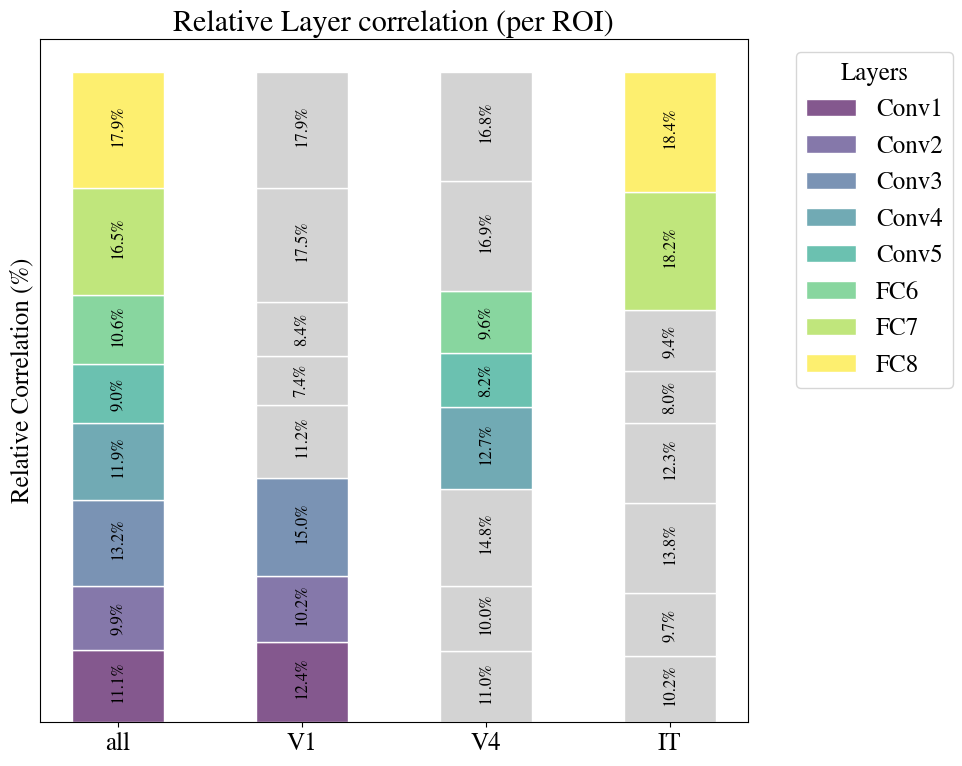

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "font.family": "STIXGeneral",
    "font.size": "18",

    # "mathtext.fontset": "stix",
})
V1_correlations = np.load(f'correlations/recons_rois/electrode_V1_recon/cor_a_electrode_V1_recon.npy')
V4_correlations = np.load(f'correlations/recons_rois/electrode_V4_recon/cor_a_electrode_V4_recon.npy')
IT_correlations = np.load(f'correlations/recons_rois/electrode_IT_recon/cor_a_electrode_IT_recon.npy')
brain = np.load(f'correlations/recons_rois/electrode_V1V4IT_recon/cor_a_electrode_V1V4IT_recon.npy')

layers = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'FC6', 'FC7', 'FC8']

V1_normalized = V1_correlations / sum(V1_correlations) * 100
V4_normalized = V4_correlations / sum(V4_correlations) * 100
IT_normalized = IT_correlations / sum(IT_correlations) * 100
brain_normalized = brain / sum(brain) * 100

max_contributions = np.argmax([V1_normalized, V4_normalized, IT_normalized], axis=0)

ind = np.arange(4)  # the x locations for the groups
width = 0.5        # the width of the bars

plt.figure(figsize=(10, 8))

# Colors for each layer
layer_colors = plt.cm.viridis(np.linspace(0, 1, len(layers)), alpha = 0.66)

# Accumulators for bottom alignment of the bars
acc_brain = np.zeros(4)
acc_v1 = np.zeros(4)
acc_v4 = np.zeros(4)
acc_it = np.zeros(4)

# Plot each layer contribution within each brain region's bar
for i, layer in enumerate(layers):
    # Set color for the layer: color if it's the max contribution, otherwise grey
    V1_color = layer_colors[i] if max_contributions[i] == 0 else 'lightgrey'
    V4_color = layer_colors[i] if max_contributions[i] == 1 else 'lightgrey'
    IT_color = layer_colors[i] if max_contributions[i] == 2 else 'lightgrey'
    brain_color = layer_colors[i]
    
    plt.bar(ind[0], brain_normalized[i], width, bottom=sum(brain_normalized[:i]), color=brain_color, edgecolor='white', label=layer if i == 0 else "")
    plt.bar(ind[1], V1_normalized[i], width, bottom=sum(V1_normalized[:i]), color=V1_color, edgecolor='white', label=layer if i == 0 else "")
    plt.bar(ind[2], V4_normalized[i], width, bottom=sum(V4_normalized[:i]), color=V4_color, edgecolor='white', label=layer if i == 0 else "")
    plt.bar(ind[3], IT_normalized[i], width, bottom=sum(IT_normalized[:i]), color=IT_color, edgecolor='white', label=layer if i == 0 else "")
    
    # Annotating each colorbox with its percentage
    plt.text(ind[0], acc_brain[0]+ brain_normalized[i]/2 - 2, f'{brain_normalized[i]:.1f}%', ha='center', color='black', fontsize=12, rotation=90)
    plt.text(ind[1], acc_v1[1] + V1_normalized[i]/2 - 2, f'{V1_normalized[i]:.1f}%', ha='center', color='black', fontsize=12, rotation=90)
    plt.text(ind[2], acc_v4[2] + V4_normalized[i]/2 - 2, f'{V4_normalized[i]:.1f}%', ha='center', color='black', fontsize=12, rotation=90)
    plt.text(ind[3], acc_it[3] + IT_normalized[i]/2 - 2, f'{IT_normalized[i]:.1f}%', ha='center', color='black', fontsize=12, rotation=90)
    
    # Updating accumulators
    acc_brain[0] += brain_normalized[i]
    acc_v1[1] += V1_normalized[i]
    acc_v4[2] += V4_normalized[i]
    acc_it[3] += IT_normalized[i]

plt.title('Relative Layer correlation (per ROI)')
plt.ylabel('Relative Correlation (%)')
plt.xticks(ind, ['all', 'V1', 'V4', 'IT'])
plt.yticks([])
# Create custom legends
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=layer_colors[i], edgecolor='white', label=layer) for i, layer in enumerate(layers)]
plt.legend(handles=legend_elements, title="Layers", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


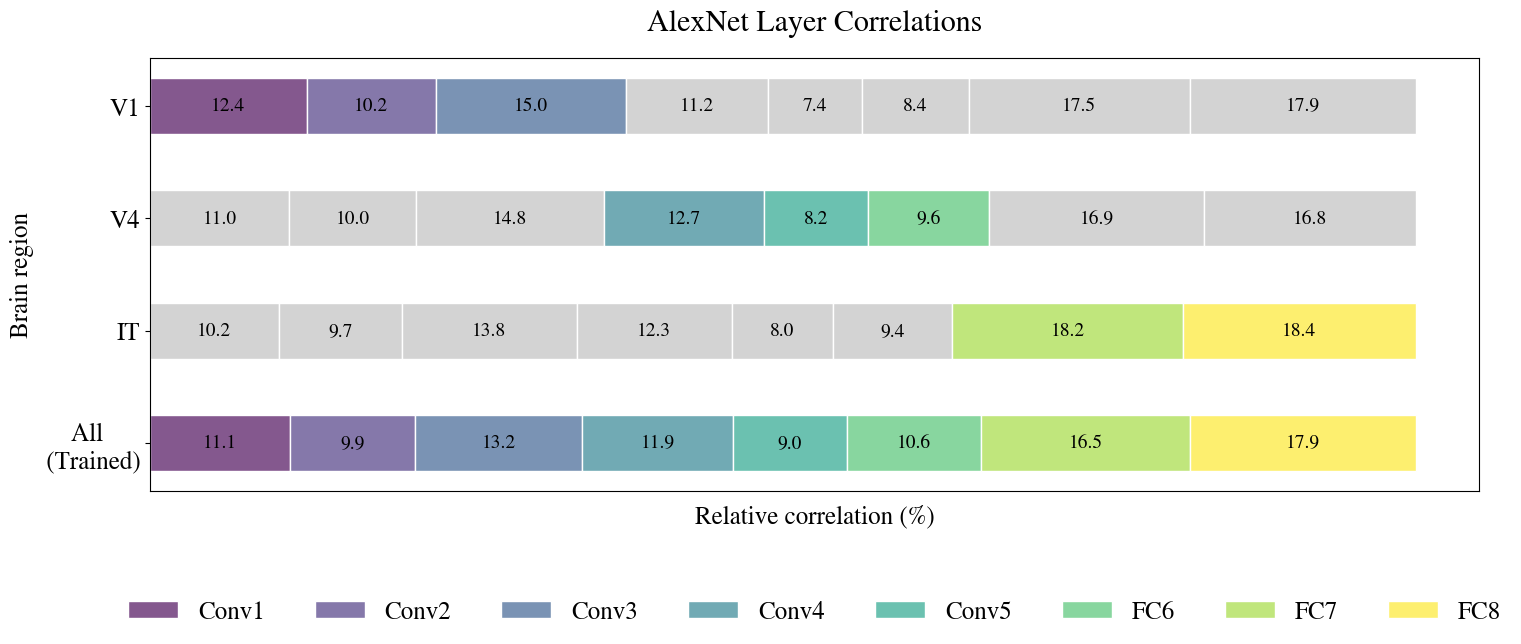

In [6]:
space = 0
layer_colors = plt.cm.viridis(np.linspace(0, 1, len(layers)), alpha = 0.66)

plt.figure(figsize=(16, 7))

# Calculate max contributions for each layer across ROIs
max_contributions_per_layer = np.argmax([brain_normalized, V1_normalized, V4_normalized, IT_normalized], axis=0)

for i, layer in enumerate(layers):
    # Determine color based on max contribution for each layer
    V1_color = layer_colors[i] if max_contributions[i] == 0 else 'lightgrey'
    V4_color = layer_colors[i] if max_contributions[i] == 1 else 'lightgrey'
    IT_color = layer_colors[i] if max_contributions[i] == 2 else 'lightgrey'
    brain_color = layer_colors[i]
        
    # Starting point for each bar segment
    start_brain = sum(brain_normalized[:i])
    start_V1 = sum(V1_normalized[:i])
    start_V4 = sum(V4_normalized[:i])
    start_IT = sum(IT_normalized[:i])
    
    # Plotting each segment
    plt.barh(0, brain_normalized[i], left=start_brain, height=0.5, color=brain_color, edgecolor='white', label=layer if i == 0 else "")

    plt.barh(1+space, IT_normalized[i], left=start_IT, height=0.5, color=IT_color, edgecolor='white')
    plt.barh(2+space, V4_normalized[i], left=start_V4, height=0.5, color=V4_color, edgecolor='white')
    plt.barh(3+space, V1_normalized[i], left=start_V1, height=0.5, color=V1_color, edgecolor='white')
    # Annotating bars with the percentage value
    if brain_normalized[i] > 0:
        plt.text(start_brain + brain_normalized[i]/2, 0, f'{brain_normalized[i]:.1f}', va='center', ha='center', color='black', fontsize=14)
    if IT_normalized[i] > 0:
        plt.text(start_IT + IT_normalized[i]/2, 1+space, f'{IT_normalized[i]:.1f}', va='center', ha='center', color='black', fontsize=14)
    if V4_normalized[i] > 0:
        plt.text(start_V4 + V4_normalized[i]/2, 2+space, f'{V4_normalized[i]:.1f}', va='center', ha='center', color='black', fontsize=14)
    if V1_normalized[i] > 0:
        plt.text(start_V1 + V1_normalized[i]/2, 3+space, f'{V1_normalized[i]:.1f}', va='center', ha='center', color='black', fontsize=14)

plt.yticks([0, 1+space, 2+space, 3+space], [ 'All      \n (Trained)', 'IT', 'V4', 'V1'])
plt.xlabel('Relative correlation (%)', labelpad = 10)
plt.ylabel('Brain region')

plt.title('AlexNet Layer Correlations', pad=20)
plt.xticks([])
# Adjusting legend
# Simplifying the legend to show one entry per layer instead of one per segment
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=layer_colors[i], edgecolor='white', label=layer) for i, layer in enumerate(layers)]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(layers), frameon=False)


plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Layer names for the x-axis
layers = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'FC6', 'FC7', 'FC8']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(layers, brain, marker='o', label='all')
plt.plot(layers, V1, marker='o', label='V1')
plt.plot(layers, V4, marker='o', label='V4')
plt.plot(layers, IT, marker='o', label='IT')

plt.title('Correlation Values by Layer for Different Brain Regions')
plt.xlabel('Layers')
plt.ylabel('Correlation Value')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
IT_correlations[[0,3,4]]

array([0.19408196, 0.14145678, 0.15222638])

In [53]:
V1_correlations = np.load(f'correlations/recons_rois/electrode_V1_recon/cor_a_electrode_V1_recon.npy')
V4_correlations = np.load(f'correlations/recons_rois/electrode_V4_recon/cor_a_electrode_V4_recon.npy')
IT_correlations = np.load(f'correlations/recons_rois/electrode_IT_recon/cor_a_electrode_IT_recon.npy')
brain = np.load(f'correlations/recons_rois/electrode_V1V4IT_recon/cor_a_electrode_V1V4IT_recon.npy')

In [ ]:



which_recons = 'recons_times'

# file_name = [
#     '25:75_forward_ori.npy',
#     '75:125_forward_ori.npy',
#     '125:175_forward_ori.npy',
#     '175:225_forward_ori.npy',
# ]

file_name = [f'electrode_{f}_recon.npy' for f in [16]]

Alexnet_layers = [
          "pool1",
          "pool2",
          "pool5",
          "fc6"
         ]

for rec in file_name:
    
    os.makedirs(f'correlations/{which_recons}/{rec[:-4]}', exist_ok = True)
    os.makedirs(f'distances/{which_recons}/{rec[:-4]}', exist_ok = True)

    cor_a = []
    dis_a = []
    
    for pool_i in Alexnet_layers:
        
        corr_alexnet, dist_alexnet = evaluate_AlexNet(pool_i, f"{which_recons}/{rec}", "stims_test.npy")
        
        print(f' values calculated for {rec} pool {pool_i}')

        cor_a.append(corr_alexnet)
        dis_a.append(dist_alexnet)
        
    np.save(f'correlations/{which_recons}/{rec[:-4]}/cor_a_{rec}', np.stack(cor_a))
    print(f' -- SAVED -- cor_a {rec} pool')
    
    np.save(f'distances/{which_recons}/{rec[:-4]}/dis_a_{rec}', np.stack(dis_a))
    print(f' -- SAVED -- dis_a {rec} pool')